### 卷积神经网络 Convnet
1.**n** 代表`input`图像的尺寸，也可以是$n \times m$   
2.**f** 代表过滤器大小，也可以是$f_n \times f_m$  
3.**fillter** 过滤器层数  
4.**s** 过滤器步幅长度  
5.**padding** 填充外圈`padding`大小  

### 基本转化公式
$$ output_{width/height} = \left \lfloor \frac{input_{width/height} - f}{s}+1  \right \rfloor \tag{1} $$  
$$ output_{width/height}= input_{width/height}+ 2 \times padding  \tag{2}$$  
$$ padding = \frac{f - 1}{2} s \tag{3}$$  

### CNN实现对植物幼苗的分类 
`Data from kaggle`

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, random_split
import torch.nn.functional as F
import seaborn as sns
import pandas as pd
import random
import numpy as np
import itertools

In [2]:
seed = 1
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

# 如果使用GPU，还需要设置
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

In [3]:
from PIL import Image
import os
data_dir = r'D:/machine_learning/DeepL/Lab/data/Plant/train'  # 替换为你的路径
max_size = (0, 0)
min_size = (float('inf'), float('inf'))
sizes = []
labels = []
# 遍历每个标签文件夹
for label in os.listdir(data_dir):
    label_dir = os.path.join(data_dir, label)
    labels.append(label)
    if os.path.isdir(label_dir):
        for img_name in os.listdir(label_dir):
            img_path = os.path.join(label_dir, img_name)
            img = Image.open(img_path)
            img_size = img.size  # 获取图片尺寸 (宽, 高)
            sizes.append(img_size)
            # 更新最大尺寸
            if img_size[0] > max_size[0] or img_size[1] > max_size[1]:
                max_size = img_size

            # 更新最小尺寸
            if img_size[0] < min_size[0] or img_size[1] < min_size[1]:
                min_size = img_size
                
print(f'总图片个数：{len(sizes)}')
print(f'最大图片尺寸: {max_size}')
print(f'最小图片尺寸: {min_size}')
print(f'标签个数：{len(labels)}')
print(labels)

总图片个数：4750
最大图片尺寸: (3991, 3457)
最小图片尺寸: (49, 49)
标签个数：12
['Black-grass', 'Charlock', 'Cleavers', 'Common Chickweed', 'Common wheat', 'Fat Hen', 'Loose Silky-bent', 'Maize', 'Scentless Mayweed', 'Shepherds Purse', 'Small-flowered Cranesbill', 'Sugar beet']


In [4]:
sizes_df = pd.DataFrame(sizes, columns=['Width', 'Height'])
sizes_df.head()

,Width,Height
0,196,196
1,388,388
2,886,886
3,117,117
4,471,471


平均宽度: 371.47 像素
平均高度: 370.73 像素


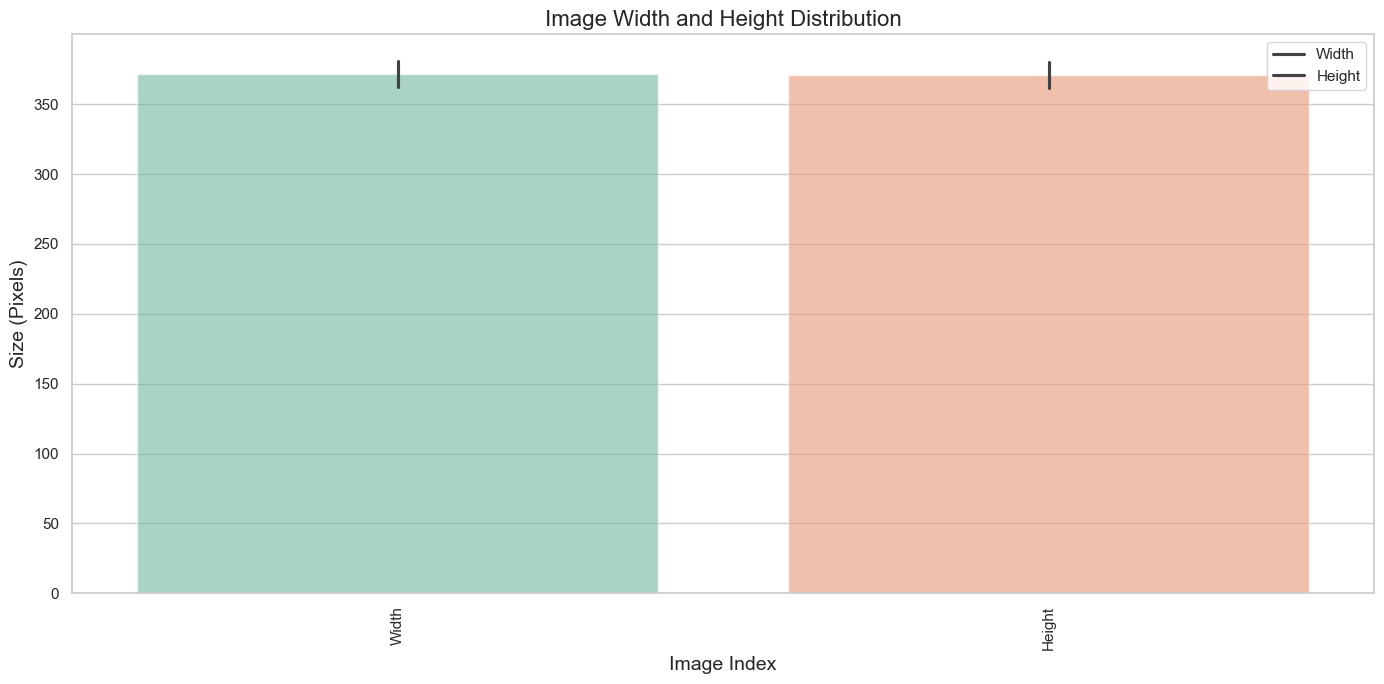

In [5]:
mean_width = sizes_df['Width'].mean()
mean_height = sizes_df['Height'].mean()
print(f'平均宽度: {mean_width:.2f} 像素')
print(f'平均高度: {mean_height:.2f} 像素')

plt.figure(figsize=(14, 7))
sns.set(style="whitegrid")
sns.barplot(data=sizes_df, palette='Set2', alpha=0.6)

plt.title('Image Width and Height Distribution', fontsize=16)
plt.xlabel('Image Index', fontsize=14)
plt.ylabel('Size (Pixels)', fontsize=14)
plt.xticks(rotation=90)
plt.legend(['Width', 'Height'], loc='upper right')
plt.tight_layout()

plt.show()

我们将图片统一化处理，**根据图片尺寸`370`设置为接近`2的幂次方`的数 `256`**  
考虑到手提式计算机我们将其设置为128  * 128

In [18]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # 调整大小
    transforms.ToTensor(),  # 转换为张量
])

dataset = datasets.ImageFolder(root=r'D:/machine_learning/DeepL/Lab/data/Plant/train', transform=transform)

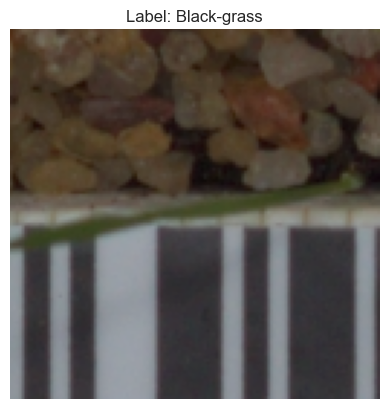

In [19]:
from torchvision.transforms import ToPILImage

image_tensor, label = dataset[0]
image = ToPILImage()(image_tensor)
plt.imshow(image)
plt.title(f'Label: {dataset.classes[label]}')
plt.axis('off')  # 关闭坐标轴
plt.show()

划分训练集

In [20]:
train_size = int(0.8 * len(dataset))  # 80% 作为训练集
val_size = len(dataset) - train_size  # 剩余 20% 作为验证集
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

定义超参数组合，考虑到笔记本电脑，我们只训练一组

In [26]:
batch_sizes = [64 + 32]
learning_rates = [0.001]
param_grid = list(itertools.product(batch_sizes, learning_rates))

CNN模型定义

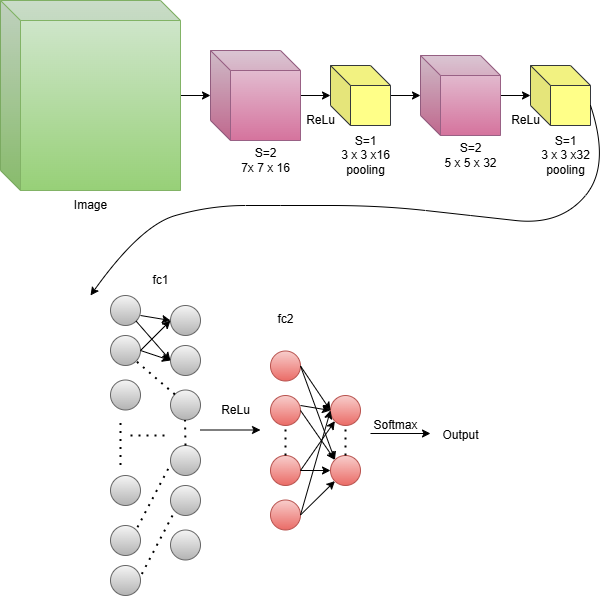

In [27]:
from IPython.display import Image
Image(r"D:\machine_learning\DeepL\img\CNNnet.png")

需要特别说明的是，由于`softmax`是概率分布，在多类分类问题中  
`torch.softmax`生成的预测值是每个类的概率分布。要将这些概率转换为类别标签，你需要使用 `torch.argmax` 而不是直接比较

In [34]:
class CustomCNN(nn.Module):
    def __init__(self, num_classes):
        super(CustomCNN, self).__init__()
        # 卷积层1: 7x7，步幅2
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=7, stride=2)  # 假设输入为3通道RGB图像
        # 池化层1: 3x3，步幅1
        self.pool1 = nn.MaxPool2d(kernel_size=3, stride=1)
        # 卷积层2: 5x5，步幅2
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=2)
        # 池化层2: 3x3，步幅1
        self.pool2 = nn.MaxPool2d(kernel_size=3, stride=1)
        # 全连接层1
        self.fc1 = nn.Linear(26 * 26 * 32, 128)  # 根据输入尺寸调整
        # 全连接层2
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        # 卷积层1
        x = self.conv1(x)
        x = F.relu(x)  # ReLU激活
        # 池化层1
        x = self.pool1(x)
        # 卷积层2
        x = self.conv2(x)
        x = F.relu(x)  # ReLU激活
        # 池化层2
        x = self.pool2(x)
        # 展平
        x = x.view(x.size(0), -1)  # 展平为(batch_size, num_features)
        # 全连接层1
        x = F.relu(self.fc1(x))
        # 全连接层2
        x = self.fc2(x)
        return x

model = CustomCNN(num_classes=len(labels))
print(model)
print(len(labels))

CustomCNN(
  (conv1): Conv2d(3, 16, kernel_size=(7, 7), stride=(2, 2))
  (pool1): MaxPool2d(kernel_size=3, stride=1, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(2, 2))
  (pool2): MaxPool2d(kernel_size=3, stride=1, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=21632, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=12, bias=True)
)
12


In [35]:
def train_model(batch_size, learning_rate):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
    
    model = CustomCNN(12).to(device)  # 将模型移动到 GPU
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()  # 适合多类分类
    
    losses = []
    val_losses = []
    val_acc = []
    for epoch in range(50):
        model.train()
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()  # 清空梯度
            outputs = model(images)  # 获取模型输出
            loss = criterion(outputs, labels)  # 计算损失
            loss.backward()  # 反向传播
            optimizer.step()  # 更新参数

        model.eval()
        val_loss = 0
        correct = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                val_loss += criterion(outputs, labels).item()
                predicted = torch.argmax(outputs, dim=1)
                correct += (predicted == labels).sum().item()

        val_loss /= len(val_loader)
        val_accuracy = correct / len(val_dataset)
        losses.append(loss.item())
        val_losses.append(val_loss)
        val_acc.append(val_accuracy)
        
        if (epoch + 1) % 10 == 0:
            # 记录损失和准确率等
            print(f'Epoch [{epoch+1}], Batch Size: {batch_size}, Learning Rate: {learning_rate}, '
                  f'Train Loss: {loss.item()}, Val Loss: {val_loss}, Val Accuracy: {val_accuracy:.4f}')
    
    return losses, val_losses, val_acc


In [36]:
losses = []
val_losses = []
val_acc = []
count = 1
for batch_size, learning_rate in param_grid:
    print(f'Count={count}, Training with batch_size={batch_size}, learning_rate={learning_rate}')
    loss, val_loss, acc = train_model(batch_size, learning_rate)
    losses.append(loss)
    val_losses.append(val_loss)
    val_acc.append(acc) 
    count += 1
print(f'Train dataset size: {len(train_dataset)}, Validation dataset size: {len(val_dataset)}')

Count=1, Training with batch_size=96, learning_rate=0.001
Epoch [10], Batch Size: 96, Learning Rate: 0.001, Train Loss: 0.6986966133117676, Val Loss: 0.8824173986911774, Val Accuracy: 0.6905
Epoch [20], Batch Size: 96, Learning Rate: 0.001, Train Loss: 0.5517396926879883, Val Loss: 0.826807360847791, Val Accuracy: 0.7453
Epoch [30], Batch Size: 96, Learning Rate: 0.001, Train Loss: 0.06605056673288345, Val Loss: 0.9508595183491707, Val Accuracy: 0.7779
Epoch [40], Batch Size: 96, Learning Rate: 0.001, Train Loss: 0.005437544081360102, Val Loss: 1.0490631679693858, Val Accuracy: 0.7958
Epoch [50], Batch Size: 96, Learning Rate: 0.001, Train Loss: 0.005763690918684006, Val Loss: 1.1996366381645203, Val Accuracy: 0.7989
Train dataset size: 3800, Validation dataset size: 950


In [42]:
print(len(losses[0]), len(val_losses[0]), len(val_acc[0]))

50 50 50


**绘制出Loss损失图像**

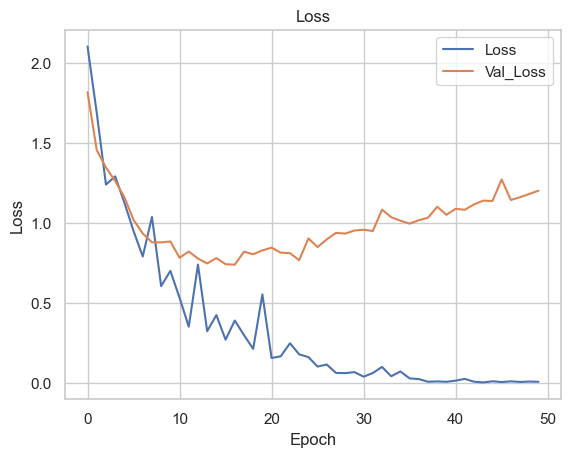

In [45]:
import matplotlib.pyplot as plt

plt.plot(losses[0])  # 训练集准确率
plt.plot(val_losses[0])
plt.title("Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Loss', 'Val_Loss'])  # 更新图例

plt.show()

**绘制出ACC**

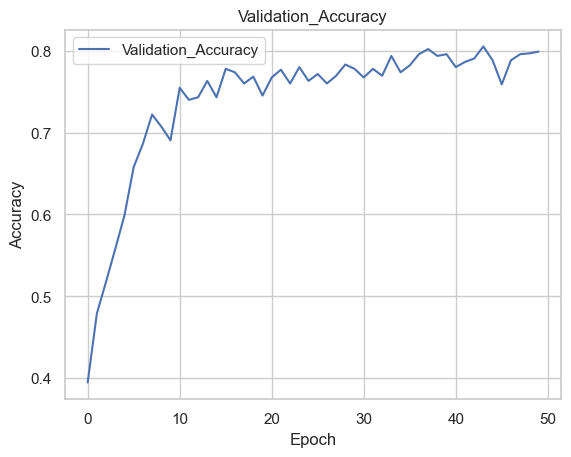

In [48]:
plt.plot(val_acc[0])  # 验证集准确率
plt.title("Validation_Accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Validation_Accuracy'])  # 更新图例
plt.show()


由于设备问题，所以设置的超参数不能很好的训练图像，在此只是样例说明

### 测试集上验证

In [61]:
import pandas as pd
from torchvision import transforms
from PIL import Image
import torch
import os

model.eval()  # 设置为评估模式
labels = ['Black-grass', 'Charlock', 'Cleavers', 'Common Chickweed', 'Common wheat', 'Fat Hen', 'Loose Silky-bent', 'Maize', 'Scentless Mayweed', 'Shepherds Purse', 'Small-flowered Cranesbill', 'Sugar beet']
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

# 测试图片路径
test_folder = "D:/machine_learning/DeepL/Lab/data/Plant/test"
output_csv = "D:/machine_learning/DeepL/Lab/data/Plant/predictions.csv"

# 存储结果
results = []

# 遍历测试集图片
for file_name in os.listdir(test_folder):
    if file_name.endswith('.png'):
        # 加载并预处理图像
        image_path = os.path.join(test_folder, file_name)
        image = Image.open(image_path).convert('RGB')
        image = transform(image).unsqueeze(0)  # 增加批次维度

        # 移动到GPU（如果可用）
        image = image.to(device)
        with torch.no_grad():
            outputs = model(image)
            _, predicted = torch.max(outputs, 1)
            label_name = labels[predicted.item()]  # 转换为标签名称

        results.append([file_name, label_name])

df = pd.DataFrame(results, columns=['file', 'species'])
df.to_csv(output_csv, index=False)
print(f"Predictions saved to {output_csv}")

Predictions saved to D:/machine_learning/DeepL/Lab/data/Plant/predictions.csv


In [3]:
df_test = pd.read_csv('D:/machine_learning/DeepL/Lab/data/Plant/predictions.csv')
df_test.head()
print(df_test.head())

            file           species
0  0021e90e4.png  Common Chickweed
1  003d61042.png  Common Chickweed
2  007b3da8b.png  Common Chickweed
3  0086a6340.png  Common Chickweed
4  00c47e980.png  Common Chickweed


**说明**：
1.该预测过程为基本预测由于设备原因, 没有对超参数网格进行调控，或者设定更好的网络结构。  
2.该过程为手动模拟, 并没有参考实际的论文参数等  
3.如要更好的预测分数,则需要使用更好的模型  
`Created by liu`